In [1]:
import numpy as np

In [2]:
def init(layersize):

   #layersize is an array the holds the number of neurals in each hidden layer 
   # which means len(layersize) represent the total of layers.
   #initialise a dict to save the parameters for each layer .  W :for the weights  and b: for the bias 
    param={} 
    for L in range(1,len(layersize)): #Looping through the layers 
        #L=1,2,3,...,len(layersize)-1
        param[f'w{L}']=np.random.randn(layersize[L],layersize[L-1]) * 0.01 # random normal distribution multiplied by 0.01 to generate smaller values
        #num of rows=num of neurons in the Lst layer, num of columns=num of neurons in the (L-1)th layer.
        param[f'b{L}']=np.zeros((layersize[L],1)) # an array of zeros for the bias (num of rows =num of neurons in the Lst layer)
    return param 

In [3]:
#defining  the activation function softmax for the last layer
def softmax(Z):
    expz=np.exp(Z-np.max(Z,axis=0,keepdims=True)) 
    return expz/np.sum(expz,axis=0,keepdims=True)

In [4]:
#defining the relative activation function for the hidden layers
def relu(Z):
    return np.maximum(0,Z)

In [5]:
def sigmoid(Z):
    return 1/(1+np.exp(-Z))

In [ ]:
#defing the forward propagation function
def forward(X,param):
    L=len(param)//2 #number of layers in the network since in the param dict we have w and b for each layer so we divide by 2
    #initialise a dict to save the output  values (activation)  for each layer
    # we store the input values X in first values as a0 .
    activ={
        'a0':X
    }
    # the 0 index is for the input layer 
    for l in range(1,L): #starting from the first  hidden layer to the one before the last.
        #we calculate Z wich is the product between the weights and the output (activation) of the previous layer + the bias
        #param[f'w{l}'] : represents the weights of the lth layer
        #activ[f'a{l-1}'] : represents the output of the previous layer (l-1)
        Z=np.dot(param[f'w{l}'] , activ[f'a{l-1}'])+param[f'b{l}']
        #next we apply the relu activation function on the calculated value Z to get the outputs of the lth layer (activations)
        a=relu(Z)
        #store Z(l) and  a(l) in the activ dict
        activ[f'z{l}']=Z
        activ[f'a{l}']=a
    # the operation on the last input will be a bit unique as we will use the softmax function to get the  final output
    # as we did previously  calculating ZL for the last layer 
    #param[f'w{L}'] :the weights of the last layer
    #activ[f'a{L-1}']:the output of the previous layer (L-1) which is the last hidden layer
    ZL = np.dot(param[f'w{L}'], activ[f'a{L-1}']) + param[f'b{L}']
    activ[f'z{L}'] = ZL  
    # we apply the softmax function to get the final output of the last layer which will give a vector of a lenght of 9 
    # the value represents  the probablities of each class [0.2,0.1,0.3,0.4,0.9,0.1,0.2,0.3,0.4] which means that 
    #the 5th class has the highest proba of being the output class (the predicted value is 5 )
    activ[f'a{L}'] = softmax(ZL) 
    return activ

In [7]:
#relu derivative function that will be used in the backward propagation to calculate the gradients 
def relu_deriv(a):
    return (a > 0).astype(float)

In [ ]:
#defining the backward propagation function
#this function will calculate the grads of the weights and bias that we gonna use in the updating process

def back_prop(param,activ,Y):
    L=len(param)//2 # total numer of layers in the network
    grads={} # init a dict to store the claculated gradienst
    m=Y.shape[1]  #num of samples in Y (trainig set size )
    #we start with the last layer
    #we calculate dz for the last layer we substrat the last output with the Y training set
    # but her Y is one hoted coded which mean that it is alos on  the form of proba vector
    dz=activ[f'a{L}']-Y
    #we store dz in grads
    grads[f'dz{L}'] = dz
    #we calculate next the dw of the last layer which is the product between dz and  the output of the previous layer (L-1).
    #we do the trasnpose because 
    grads[f'dw{L}']=1/m* np.dot(dz,activ[f'a{L-1}'].T)
    #we calculate the b  graadient by summing the dz vector 
    grads[f"db{L}"] = (1 / m) * np.sum(dz, axis=1, keepdims=True)
    for l in reversed(range(1,L)):#looping the layers in reverse order from the one before the last to the first hidden layer
        w_next=param[f'w{l+1}']
        dz_next=grads[f'dz{l+1}']

        grads[f'dz{l}']=np.dot(w_next.T,dz_next)*relu_deriv(activ[f'a{l}'])
        grads[f'dw{l}']=(1/m)*np.dot(grads[f'dz{l}'],activ[f'a{l-1}'].T)
        grads[f'db{l}']=(1/m)*np.sum(grads[f'dz{l}'],axis=1,keepdims=True)
    return grads 
    

In [10]:
#defyning the update funct that used to update the weights and the bias of each layer using the gradients from the backward propagation 

def update(para,gradients,lr):
    L=len(para)//2
    for l in range(1,L+1):
        para[f'w{l}']-=lr*gradients[f'dw{l}'] 
        para[f'b{l}']-=lr*gradients[f'db{l}']
    return para

In [11]:
#the prediction function that predict the output from the input
def predict(X,para):
    activ=forward(X,para) # applying the forward function that returns the dict of actiavtions 
    L=len(para)//2 # the number of layer
    return np.argmax(activ[f'a{L}'],axis=0) #getting the index of the value that has the highest proba which is the predicted value


In [12]:
#the loss function

def loss(AL, Y):
    m = Y.shape[1]
    return -np.sum(Y * np.log(AL + 1e-8)) / m  # 1e-8 is epsilon to prevent the case of np.log(0) which is undefined 


In [ ]:
#the main function of our program that train the dataset 

def train(X,Y,sizes,lr=0.01,iter=2000):
     #X is the training dataset.
     #Y is the real values.
     #we apply the init funtion previously defined to initialise the w and bias matrix and vvectors for each layer
     # by giving as a parameter sizes which is a vector that holds the number of neurons in eaach layer
     param=init(sizes) 
     #an array for storing the losses in each iteration
     cost=[]
     #an array too for storing the accuracies
     accuracy=[]
    
     for i in range(iter):#looping through num of iterations
            #calling for the foward function to calculate the activations (outut values) for each layer
            activ=forward(X,param)
            #calculating the loss by calling  the loss function
            err=loss(activ[f'a{len(sizes)-1}'], Y)
            # we calculate the grads by calling backpropagation that returns the dict of  gradients
            grads=back_prop(param,activ,Y)
            #add err to cost 
            cost.append(err)
            #making a prediction with the current params to calculate the accuracy 
            preds=predict(X,param)
            #getting the labels from Y by applying argmax since Y is a vector of proba we retur the index of the value that hsd the  highest proba 
            true_labels=np.argmax(Y,axis=0)
            #calculatiing the accuracy which is the mean of the number of the correct prediction 
            acc=np.mean(preds==true_labels)
            #we add acuuracy to the array  for this iteration
            accuracy.append(acc)
            #we apply the update function to update the weights and bias for each layer 
            # we repeat the process for 2000 iter
            param=update(param,grads,lr)
            if i % 100 == 0:
                print(f"Epoch {i}, Loss: {loss(activ[f'a{len(sizes)-1}'], Y)}")
     return param,cost,accuracy  

In [14]:
# definint one hot function that turns the value of Y into a vector of a probabilities
# for exemple if Y[1]=9 the Y[1] value will become [0,0,0,0,0,0,0,0,1]

def one_hot(Y, num_classes):
    one_hot_Y = np.zeros((num_classes, Y.size)) #create the zeros vector that has a lenght of the number of classes in our case is 9
    one_hot_Y[Y, np.arange(Y.size)] = 1 # then turn the  value of the index  Y to 1 
    return one_hot_Y

In [25]:
from sklearn.datasets import fetch_openml

# Load MNIST dataset
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)


X = X / 255.0  # normalize X


# Convert labels to integers and apply one-hot encoding
y = y.astype(int)

Y = one_hot(y.to_numpy(), 10)  # Apply one-hot encoding

#call the train function 
# training set  will be 10000 samples
#sizes :
#input layer will be 28 * 28 => 748 
#first hidden layer 128 neurals
#second hidden layer 64 neurals
#last layer the output 10 neurals 
#learning rate 0.1
#num of iteration 5000
parameters,cost ,acuracy  = train(X[:10000].T, Y[:, :10000], sizes=[784, 128, 64, 10], lr=0.1,iter=1000)





Epoch 0, Loss: 2.3025498006816467
Epoch 100, Loss: 2.2999155023082354
Epoch 200, Loss: 2.2968042660103807
Epoch 300, Loss: 2.207974045777236
Epoch 400, Loss: 1.270203183415091
Epoch 500, Loss: 0.7910768905419443
Epoch 600, Loss: 0.606997778383503
Epoch 700, Loss: 0.524016676915036
Epoch 800, Loss: 0.45814016778376443
Epoch 900, Loss: 0.39616442238589394


In [16]:
import matplotlib.pyplot as plt

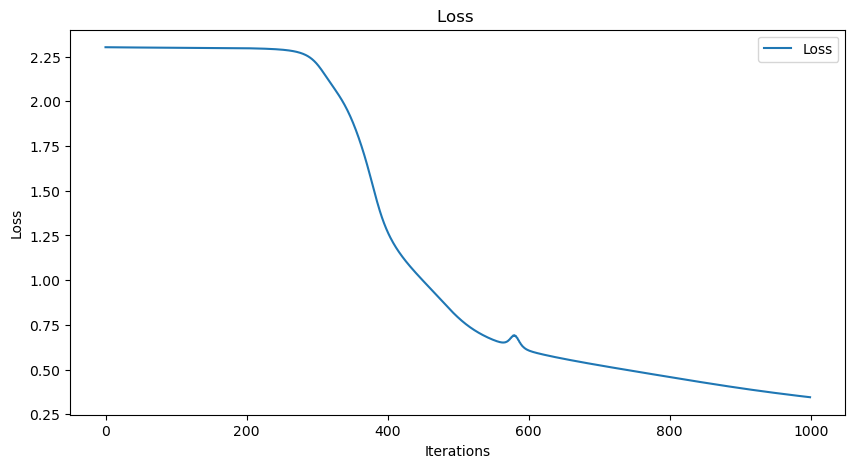

In [26]:
plt.figure(figsize=(10, 5))
plt.plot(cost, label="Loss")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Loss ")
plt.legend()
plt.show()

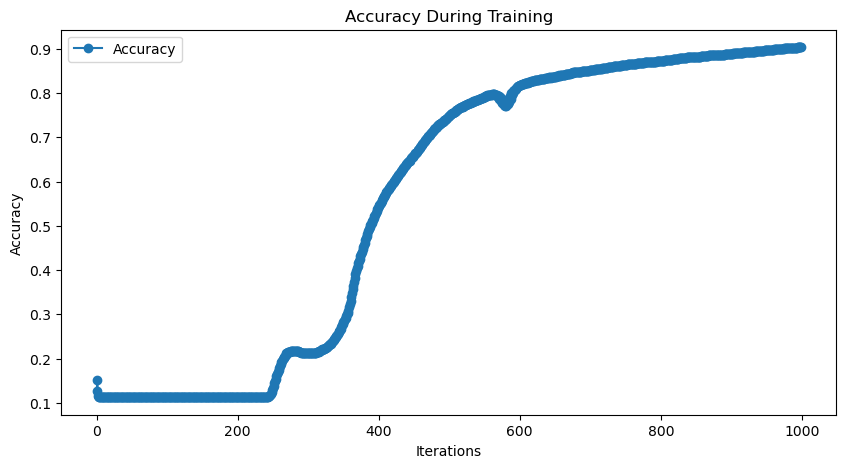

In [27]:
plt.figure(figsize=(10, 5))
plt.plot(range(len(acuracy)), acuracy, label="Accuracy", marker='o')  # Pass the 'accuracy' list here
plt.xlabel("Iterations")
plt.ylabel("Accuracy")
plt.title("Accuracy During Training")
plt.legend()
plt.show()

In [19]:
from sklearn.metrics import confusion_matrix, classification_report

In [28]:
outputs = forward(X[11000:20000].T, parameters)['a' + str(len(parameters)//2)]
preds = np.argmax(outputs, axis=0)


#  accuracy
accuracy = np.mean(preds == y[11000:20000]) * 100
print(f"Accuracy: {accuracy:.2f}%")

Accuracy: 87.46%


In [29]:
true_labels = y[11000:20000]

cm=confusion_matrix(true_labels,preds)
print(cm)

[[844   0  17   1   0  22   6   2   3   1]
 [  0 992   6   5   2   3   0   2  31   1]
 [  4  15 724  22  10   5  24   7  27   3]
 [  4  15  36 773   0  59   4  11  33   6]
 [  1   1   8   0 749   2  17   2   7  72]
 [ 12   3  17  33   8 680  17   1  32  14]
 [  6   2  23   0  16  14 784   0   8   1]
 [  1  12  11   6   7   0   0 863   2  24]
 [  0  20  14  41   6  46   8   2 715  40]
 [  8   5   3  11  73  10   2  57  16 747]]


In [30]:
report=classification_report(true_labels,preds)
print(report)

              precision    recall  f1-score   support

           0       0.96      0.94      0.95       896
           1       0.93      0.95      0.94      1042
           2       0.84      0.86      0.85       841
           3       0.87      0.82      0.84       941
           4       0.86      0.87      0.87       859
           5       0.81      0.83      0.82       817
           6       0.91      0.92      0.91       854
           7       0.91      0.93      0.92       926
           8       0.82      0.80      0.81       892
           9       0.82      0.80      0.81       932

    accuracy                           0.87      9000
   macro avg       0.87      0.87      0.87      9000
weighted avg       0.87      0.87      0.87      9000



<>:32: SyntaxWarning: invalid escape sequence '\i'
<>:32: SyntaxWarning: invalid escape sequence '\i'
C:\Users\USER\AppData\Local\Temp\ipykernel_15316\1000900171.py:32: SyntaxWarning: invalid escape sequence '\i'
  img_vector = preprocess_image('images\im3.jpeg')


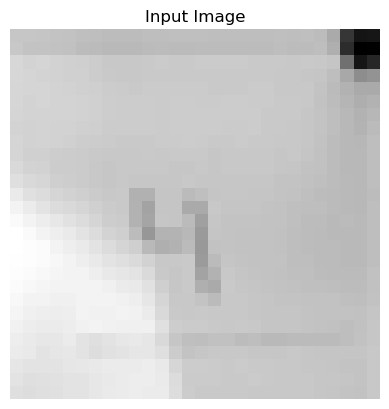

Predicted digit: [3]


In [ ]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

def preprocess_image(path):
  
    img = Image.open(path).convert('L')  

    # Resize to 28x28
    img = img.resize((28, 28))
     
  
    img_array = np.array(img)


    plt.imshow(img_array, cmap='gray')
    plt.title("Input Image")
    plt.axis("off")
    plt.show()

    if img_array.mean() > 127:  
        img_array = 255 - img_array 

    # Normalize pixel values
    img_array = img_array / 255.0

    img_vector = img_array.reshape(784, 1)

    return img_vector


img_vector = preprocess_image('images\im3.jpeg')
pred = predict(img_vector, parameters)
print(f"Predicted digit: {pred}")

In [ ]:
import pickle

In [ ]:

with open("model.pkl", "wb") as file:
    pickle.dump(parameters, file)


<>:6: SyntaxWarning: invalid escape sequence '\i'
<>:6: SyntaxWarning: invalid escape sequence '\i'
C:\Users\USER\AppData\Local\Temp\ipykernel_15316\965942828.py:6: SyntaxWarning: invalid escape sequence '\i'
  img_vector = preprocess_image('images\im11.png')


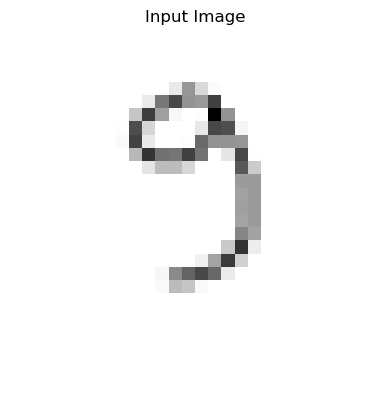

Predicted digit: [7]


In [ ]:


with open ("model.pkl","rb") as file:
    parameters = pickle.load(file)



img_vector = preprocess_image('images\im11.png')
pred = predict(img_vector, parameters)
print(f"Predicted digit: {pred}")

